# Double counterfactual prediction

## We will be performing a double counterfactual prediction in this tutorial, recreating the CellDISECT results from benchmarking scenario 2 of the paper on the Eraslan et al. data.

In [1]:
# enable autoreload
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import random

import scvi
scvi.settings.seed = 0
import scanpy as sc
import anndata as ad
import torch
import numpy as np
import pandas as pd
import gc
import scipy
from scipy.stats import pearsonr
from scipy.stats import wasserstein_distance
torch.set_float32_matmul_precision('medium')
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import seaborn as sns

import warnings
from tqdm import tqdm
warnings.simplefilter("ignore", UserWarning)
warnings.filterwarnings("ignore")


from celldisect import CellDISECT

Global seed set to 0
Global seed set to 0


In [2]:
RANDOM_SEED = 42

adata = sc.read_h5ad('/lustre/scratch126/cellgen/team205/aa34/Arian/Dis2P/eraslan_preprocessed1212_split_deg.h5ad')
adata = adata[adata.layers['counts'].sum(1) != 0].copy()
if scipy.sparse.issparse(adata.X):
    adata.X = adata.X.todense()
if scipy.sparse.issparse(adata.layers['counts']):
    adata.layers['counts'] = adata.layers['counts'].todense()
    
adata.X = adata.layers['counts'].copy()

cats = ['tissue', 'Sample ID', 'sex', 'Age_bin']

In [3]:
cell_type_included = False # Set to True if you have provided a cell type annotation in the cats list

if not cell_type_included:
    adata.obs["_cluster"] = (
        "0"  # Dummy obs for inference (not-training) time, to avoid computing neighbors and clusters again in setup_anndata | AVOID ADDING BEFORE TRAINING
    )

In [4]:
n_samples_from_source_max = 500

## We have already trained the model without cell type information using the default parameters as in the example:
https://github.com/Lotfollahi-lab/CellDISECT/blob/main/examples/training_example.py

In [5]:
pre_path = '/lustre/scratch126/cellgen/team205/aa34/Arian/Dis2P/models/'

split_name = 'split_2'
gc.collect()

celldisect_model_path = (
    f'dis2p_cE_{split_name}/'
f'pretrainAE_0_maxEpochs_1000_split_{split_name}_reconW_20_cfWeight_0.8_beta_0.003_clf_0.05_adv_0.014_advp_5_n_cf_1_lr_0.003_wd_5e-05_new_cf_True_dropout_0.1_n_hidden_128_n_latent_32_n_layers_2batch_size_256_NoCT'
)

model = CellDISECT.load(f"{pre_path}/{celldisect_model_path}", adata=adata)

INFO     File                                                                                                      
         /lustre/scratch126/cellgen/team205/aa34/Arian/Dis2P/models//dis2p_cE_split_2/pretrainAE_0_maxEpochs_1000_s
         plit_split_2_reconW_20_cfWeight_0.8_beta_0.003_clf_0.05_adv_0.014_advp_5_n_cf_1_lr_0.003_wd_5e-05_new_cf_T
         rue_dropout_0.1_n_hidden_128_n_latent_32_n_layers_2batch_size_256_NoCT/model.pt already downloaded        


Cluster covariate already present in adata.obs, remove in case you want to re-run, skipping!


## We are aiming to predict, what would Epithelial female breast cells look like, given if they were male prostate gland cells.
### So this is a double counterfactual, aiming to change 2 of the covariates at the same time in the cells, `sex`, and `tissue` in this case.
We are also using just the Epithelial subset of the dataset, since we want to do the counterfactuals on this group of cells.
You can take a look at the documentation of the `predict_counterfactuals` method for more details.

In [6]:
cell_type_to_check = 'Epithelial cell (luminal)'
n_samples_from_source = min(n_samples_from_source_max, len(adata[(adata.obs['Broad cell type'] == cell_type_to_check) &
                (adata.obs['tissue'] == 'breast') & (adata.obs['sex'] == 'female')]))


cov_names = ['sex', 'tissue']
cov_values = ['female', 'breast']
cov_values_cf = ['male', 'prostate gland']

adata_ = adata[adata.obs['Broad cell type'] == cell_type_to_check].copy()

In [7]:
x_ctrl, x_true, x_pred = model.predict_counterfactuals(
                                        adata_,
                                        cov_names=cov_names,
                                        cov_values=cov_values,
                                        cov_values_cf=cov_values_cf,
                                        cats=cats,
                                        n_samples_from_source=n_samples_from_source,
                                        seed=RANDOM_SEED,
                                        )

x_ctrl, x_true, x_pred = np.log1p(x_ctrl), np.log1p(x_true), np.log1p(x_pred)

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


The `predict_counterfactuals` method gave us the `control cells (female breast)`, `true cells (actual male prostate)`, and `CellDISECT's prediction of female breast --> male prostate` as output.

We have the differentially expressed genes related to this transformation precomputed. You can compute these genes with the code in the following notebook:
https://github.com/stathismegas/CellDISECT_reproducibility/blob/main/figure_notebooks/eraslan/eraslan_preprocess_scenario_splits.ipynb

In [8]:
deg_list = adata.uns['rank_genes_groups_split_2']['male_prostate gland']

In [9]:
deg_list

array(['KLK4', 'AC005152.3', 'LINC01152', 'HP', 'CD177', 'KLK3',
       'PLA2G2A', 'XIST', 'KLK2', 'CPLX3', 'NKX3-1', 'RP11-395B7.2',
       'MSMB', 'ATOH8', 'ACPP', 'MT1G', 'S100P', 'ANKRD30A', 'NEFH',
       'IFI6', 'PCAT4', 'PGC', 'FTL', 'SLC45A3', 'CKB', 'GP2',
       'LINC01297', 'SLC38A11', 'MT1M', 'RPS4Y1', 'FGL1', 'RP1-288H2.2',
       'PLPP1', 'SORD', 'AKAP12', 'CYP1B1', 'SFN', 'ADIRF', 'CPNE4',
       'GPX3', 'UBA52', 'TIMP1', 'KIT', 'TMEFF2', 'TRPM8', 'ATP5E',
       'GABRP', 'HSPA1A', 'STAC2', 'UQCR10', 'MT2A', 'HERPUD1', 'S100A11',
       'SCD', 'RP11-33A14.1', 'SLC4A4', 'MT1E', 'PSCA', 'RP11-126O1.4',
       'UBB', 'VTCN1', 'IFITM3', 'AGR2', 'SCNN1G', 'TMSB10', 'NDUFA4',
       'SCHLAP1', 'AMD1', 'B2M', 'NDRG1', 'PSAP', 'KRT15', 'RP11-384F7.2',
       'STEAP2', 'CPE', 'COX7C', 'FAU', 'PRDX1', 'AQP3', 'ALOX15B',
       'GADD45G', 'SHROOM1', 'SERF2', 'LSAMP', 'DHCR24', 'UQCRB', 'ZNF90',
       'C19orf48', 'POLR2L', 'COX6B1', 'CST3', 'TXNRD1', 'ESR1', 'OOEP',
       'HGD', '

## Earth Mover's Distance metric on 20 DEGs and all genes

In [13]:
emd_results = {}
for n_top_deg in [20, None]:
    if n_top_deg is not None:
        degs = np.where(np.isin(adata.var_names, deg_list[:n_top_deg]))[0]
    else:
        degs = np.arange(adata.n_vars)
        n_top_deg = 'all'

    x_true_deg = x_true[:, degs]
    x_pred_deg = x_pred[:, degs]
    x_ctrl_deg = x_ctrl[:, degs]
    
    emd_results[str(n_top_deg)] = {}
    for method_name, method in zip(['CellDISECT', 'Control'], [x_pred_deg, x_ctrl_deg]):
        wd = []
        for i in range(x_true_deg.shape[1]):
            wd.append(
                wasserstein_distance(torch.tensor(x_true_deg[:, i]), torch.tensor(method[:, i]))
            )
        emd_results[str(n_top_deg)][method_name] = np.mean(wd)

emd_results = pd.DataFrame.from_dict(emd_results).T
emd_results

,CellDISECT,Control
20,0.506272,0.636810
all,0.108333,0.088362


## Pearson Correlation metric on 20 DEGs and all genes

In [15]:
r2_results = {}
for n_top_deg in [20, None]:
    if n_top_deg is not None:
        degs = np.where(np.isin(adata.var_names, deg_list[:n_top_deg]))[0]
    else:
        degs = np.arange(adata.n_vars)
        n_top_deg = 'all'

    x_true_deg = x_true[:, degs]
    x_pred_deg = x_pred[:, degs]
    x_ctrl_deg = x_ctrl[:, degs]
    

    r2_mean_deg = pearsonr(x_true_deg.mean(0), x_pred_deg.mean(0))
    r2_mean_base_deg = pearsonr(x_true_deg.mean(0), x_ctrl_deg.mean(0))
    
    r2_var_deg = pearsonr(x_true_deg.var(0), x_pred_deg.var(0))
    r2_var_base_deg = pearsonr(x_true_deg.var(0), x_ctrl_deg.var(0))
    
    r2_results[str(n_top_deg)] = {}
    r2_results[str(n_top_deg)]['CellDISECT'] = r2_mean_deg[0]
    r2_results[str(n_top_deg)]['Control'] = r2_mean_base_deg[0]

    r2_results[str(n_top_deg)]['CellDISECT_var'] = r2_var_deg[0]
    r2_results[str(n_top_deg)]['Control_var'] = r2_var_base_deg[0]
    
r2_results = pd.DataFrame.from_dict(r2_results).T
r2_results

,CellDISECT,Control,CellDISECT_var,Control_var
20,0.889936,-0.323958,0.780835,-0.311901
all,0.490695,0.282120,0.568846,0.292532


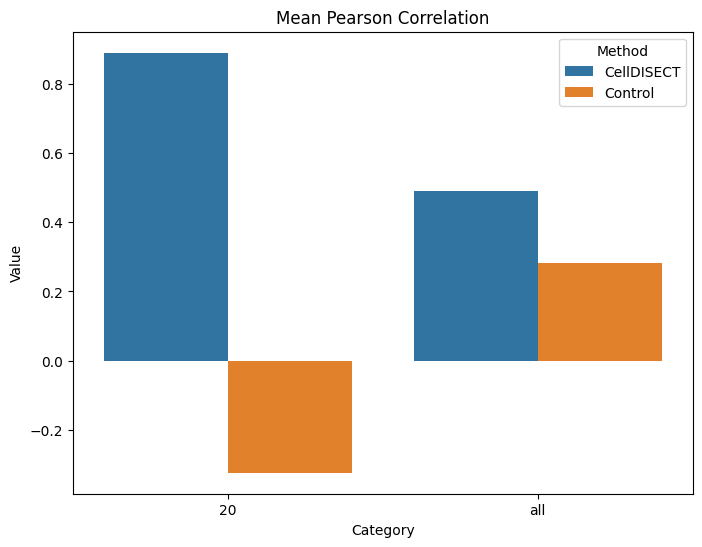

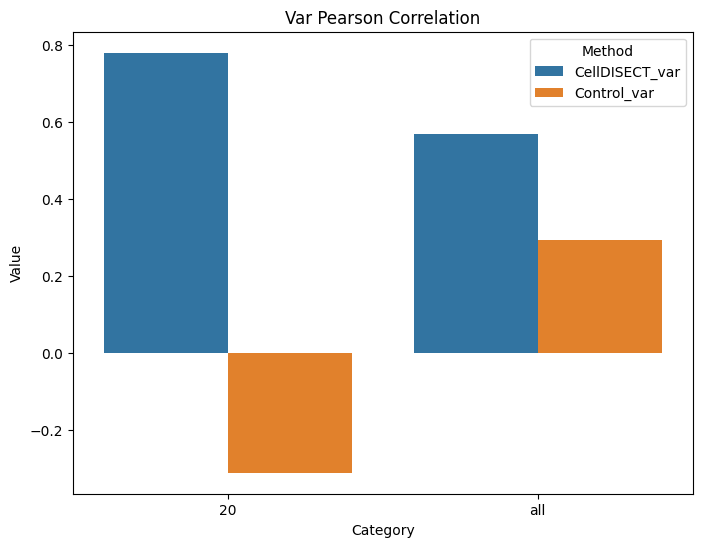

In [23]:
df_long = r2_results[['CellDISECT', 'Control']].reset_index().melt(id_vars='index', 
                                       var_name='Method', 
                                       value_name='Value')
df_long.rename(columns={'index': 'Category'}, inplace=True)

# Create the grouped barplot
plt.figure(figsize=(8, 6))
sns.barplot(data=df_long, x='Category', y='Value', hue='Method')

# Customize the plot
plt.title("Mean Pearson Correlation")
plt.ylabel('Value')

# Show the plot
plt.show()

df_long = r2_results[['CellDISECT_var', 'Control_var']].reset_index().melt(id_vars='index', 
                                       var_name='Method', 
                                       value_name='Value')
df_long.rename(columns={'index': 'Category'}, inplace=True)

# Create the grouped barplot
plt.figure(figsize=(8, 6))
sns.barplot(data=df_long, x='Category', y='Value', hue='Method')

# Customize the plot
plt.title("Var Pearson Correlation")
plt.ylabel('Value')

# Show the plot
plt.show()

## Delta Pearson Correlation metric on 20 DEGs and all genes

In [16]:
r2_results_subtract = {}
for n_top_deg in [20, None]:
    if n_top_deg is not None:
        degs = np.where(np.isin(adata.var_names, deg_list[:n_top_deg]))[0]
    else:
        degs = np.arange(adata.n_vars)
        n_top_deg = 'all'

    x_true_deg = x_true[:, degs]
    x_pred_deg = x_pred[:, degs]
    x_ctrl_deg = x_ctrl[:, degs]
    

    r2_mean_deg = pearsonr(x_true_deg.mean(0) - x_ctrl_deg.mean(0), x_pred_deg.mean(0) - x_ctrl_deg.mean(0))
    
    r2_var_deg = pearsonr(x_true_deg.var(0) - x_ctrl_deg.var(0), x_pred_deg.var(0) - x_ctrl_deg.var(0))
    
    r2_results_subtract[str(n_top_deg)] = {}
    r2_results_subtract[str(n_top_deg)]['CellDISECT'] = r2_mean_deg[0]

    r2_results_subtract[str(n_top_deg)]['CellDISECT_var'] = r2_var_deg[0]
    
r2_results_subtract = pd.DataFrame.from_dict(r2_results_subtract).T
r2_results_subtract

,CellDISECT,CellDISECT_var
20,0.729744,0.641065
all,0.400509,0.151026
